# Hyperparameter Tunning for the Inception Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import mse

from function_lib import *
from network_tf2 import *

#Checking for GPU access
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-04-19 08:52:57.867374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 08:52:58.707604: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0
2023-04-19 08:52:58.717917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


### Data preparation

In [2]:
'''
data = np.load('/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download')

cat = pd.DataFrame(data["labels"][:30000] )
np.save('data/z_30k.npy', cat.z)

images = data['cube'][:30000]
np.save('data/img_30k.npy', images)
'''

'\ndata = np.load(\'/global/cfs/cdirs/lsst/groups/PZ/valentin_image_data_temp/download\')\n\ncat = pd.DataFrame(data["labels"][:30000] )\nnp.save(\'data/z_30k.npy\', cat.z)\n\nimages = data[\'cube\'][:30000]\nnp.save(\'data/img_30k.npy\', images)\n'

In [3]:
img = np.load('data/img_30k.npy')
z = np.load('data/z_30k.npy')
print(img.shape, z.shape)

(30000, 64, 64, 5) (30000,)


In [4]:
# Scaling the images
from scipy.stats import median_abs_deviation
scaling = []
for i,b in enumerate(['g', 'r', 'i', 'z', 'y']):
    sigma = 1.4826*median_abs_deviation(img[...,i].flatten())
    scaling.append(sigma)

def preprocessing(image):
    return np.arcsinh(img / scaling / 3. )

img = preprocessing(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


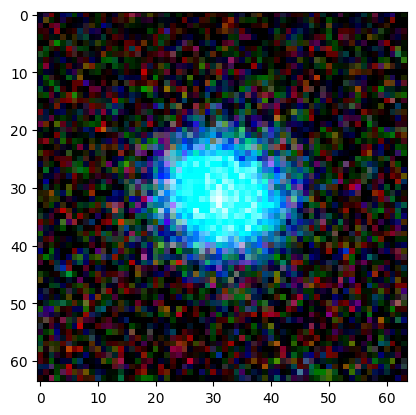

In [5]:
# Check transformed images
plt.imshow(img[0, ..., :3]);

In [6]:
# Split into train, validation and test sets taking 10,000 samples each
img_train = img[:10000,...]
img_val = img[10000:20000,...]
img_test = img[20000:,...]

z_train = z[:10000]
z_val = z[10000:20000]
z_test = z[20000:]

### Model Training 

In [7]:
def model_tf2(with_ebv = False, output_distrib=False, num_components=16):
    
    Image = Input(shape=(64, 64, 5))
    if with_ebv:
        reddening = Input(shape=(1))
    
    conv0 = Conv2D(filters=64, kernel_size=5, padding='same')(Image)
    prelu0 = PReLU()(conv0)
    pool0 = AveragePooling2D(pool_size=2, strides=2, padding='same')(prelu0)
    
    i0 = inception(pool0, 48, 64, name="I0_", output_name="INCEPTION0")
    
    i1 = inception(i0, 64, 92, name="I1_", output_name="INCEPTION1")
    pool1 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i1)
    
    i2 = inception(pool1, 92, 128, name="I2_", output_name="INCEPTION2")
    
    i3 = inception(i2, 92, 128, name="I3_", output_name="INCEPTION3")
    pool2 =AveragePooling2D(pool_size=2, strides=2, padding='same')(i3)
    
    i4 = inception(pool2, 92,128, name="I4_", output_name="INCEPTION4", without_kernel_5=True)
    
    flatten = Flatten()(i4)
    if with_ebv:
        concat = Concatenate()([flatten, reddening])
        d0 = Dense(1024, activation='relu')(concat)
    else:
        #dropout_0 = tf.keras.layers.Dropout(0.3)(flatten)
        d0 = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(flatten)
        # , kernel_regularizer=tf.keras.regularizers.L1(l1=0.0001)
        
    #dropout_1 = tf.keras.layers.Dropout(0.3)(d0)
    d1 = Dense(1024, activation='relu')(d0)
    
    #d2 = Dense(512, activation='relu')(d1)
    
    if not output_distrib:
        #dropout_out = tf.keras.layers.Dropout(0.5)(d1)
        outputs = Dense(1)(d1)
    else:
        '''
        categorical_logits = Dense(num_components)(d1)
        alpha = 1 +  Dense(num_components, activation='softplus')(d1)
        beta = 1 + Dense(num_components, activation='softplus')(d1)
        concat = Concatenate()([categorical_logits, alpha, beta])
        
        outputs = tfp.distributions.Independent(tfp.distributions.MixtureSameFamily(
            mixture_distribution=tfp.distributions.Categorical(logits=concat[..., :num_components]),
            components_distribution=tfp.distributions.Beta(concat[..., num_components:2*num_components], concat[..., 2*num_components:])))(concat)
        '''
        param = Dense(3*num_components)(d1)
   
        outputs = tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(logits=tf.expand_dims(t[..., :num_components], -2)),
                components_distribution=tfd.Beta(
                    1 + tf.nn.softplus(tf.expand_dims(t[..., num_components:2*num_components], -2)),
                    1 + tf.nn.softplus(tf.expand_dims(t[..., 2*num_components:],-2)))), 1))(param)
    
    if with_ebv:
        model = Model(inputs=[Image, reddening], outputs=outputs, name="incept_model")
    else:
        model = Model(inputs=Image, outputs=outputs, name="incept_model")
        
    return model


In [8]:
model = model_tf2()
model.summary()

2023-04-19 08:53:32.694893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


Model: "incept_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 5)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   8064        ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   262144      ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 32, 32, 64)  0           ['p_re_lu[0][0]']                
 ing2D)                                                                                

In [9]:
model.compile(optimizer='adam', loss=mse)

In [11]:
# Learning rate schedule
LEARNING_RATE=0.001
LEARNING_RATE_EXP_DECAY=0.9
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

# Tensoboard tracking
tb_callback = tf.keras.callbacks.TensorBoard('./tunning/dense1_l1', update_freq='batch')
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

model.fit(x = img_train, 
          y = z_train,
          batch_size = 64,
          validation_data=(img_val, z_val),
          steps_per_epoch=10000//64,
          epochs=4,
          callbacks=[lr_decay, tb_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/4


2023-04-19 08:54:07.656082: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2023-04-19 08:54:09.261903: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


156/156 [==============================] - 17s 48ms/step - loss: 0.5272 - val_loss: 0.1987 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000000000001.
Epoch 2/4
156/156 [==============================] - 6s 40ms/step - loss: 0.1444 - val_loss: 0.1027 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008100000000000001.
Epoch 3/4
156/156 [==============================] - 6s 40ms/step - loss: 0.0797 - val_loss: 0.0606 - lr: 8.1000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007290000000000002.
Epoch 4/4
156/156 [==============================] - 6s 40ms/step - loss: 0.0491 - val_loss: 0.0392 - lr: 7.2900e-04


313/313 [==============================] - 2s 6ms/step
Prediction bias: 0.0167


<IPython.core.display.Latex object>

Outlier fraction: 11.35%


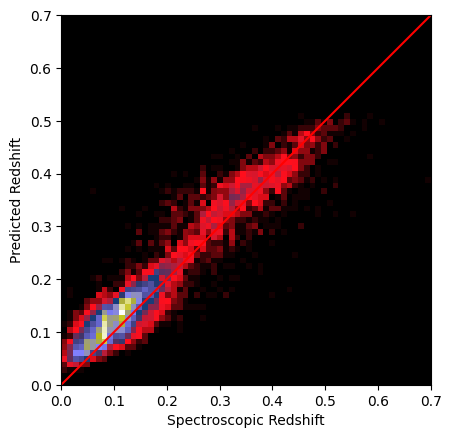

In [12]:
# Get the prediction and plot the results
preds = model.predict(img_test).squeeze()

plt.hist2d(z_test, preds, 64, range=[[0,0.7],[0,0.7]], cmap='gist_stern'); 
plt.gca().set_aspect('equal');
plt.plot([0,0.7],[0,0.7],color='r')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Predicted Redshift');

dz, pred_bias, smad, out_frac = metrics(z_test, preds)
print_metrics(pred_bias, smad, out_frac)